In [1]:
from ml_model import nn
from numerical_model import lorenz96

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

Instructions for updating:
Colocations handled automatically by placer.


2024-05-22 10:56:30.074285: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-05-22 10:56:30.136364: W tensorflow/c/c_api.cc:305] Operation '{name:'conv1d_4/bias/Assign' id:205 op device:{requested: '', assigned: ''} def:{{{node conv1d_4/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv1d_4/bias, conv1d_4/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [258]:
print(n_steps, dt, t_tot)

400 0.05 0.2


Text(0.5, 1.0, 'Avg Error across 40 components')

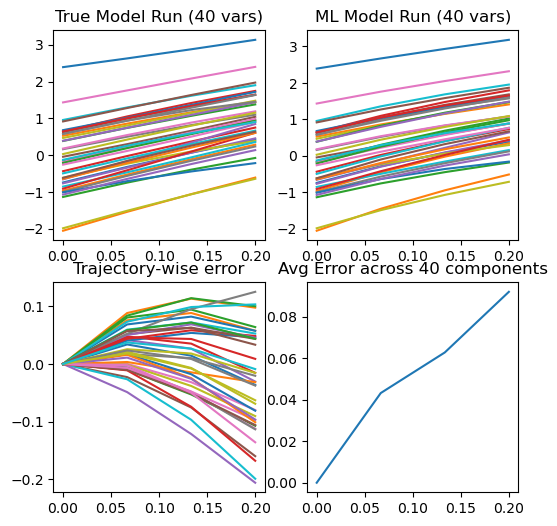

In [259]:
# Time step for the ML model; use the same for the numerical integration
# total time 
t_tot = .2
n_steps = 4
dt = t_tot / n_steps

# Generate a random state
x0 = np.random.randn(40)

x = x0
x_ml = np.zeros((n_steps, 40))
x_ml[0] = x0
for i in range(1, n_steps):
    x = nn._smodel.predict(x.reshape((1, 40, 1)))[0, :, 0]
    x_ml[i] = x

x_phys = solve_ivp(lorenz96, [0, n_steps*dt], x0, t_eval=np.arange(0.0, n_steps*dt, dt)).y.T

time = np.linspace(0, dt * n_steps, x_phys.shape[0])
# plot physical trajectory, nn trajectory and error with time on the x-axis
fig, ax = plt.subplots(2,2, figsize=(6,6))
ax[0,0].plot(time, x_phys)
ax[0,0].set_title("True Model Run (40 vars)")
ax[0,1].plot(time, x_ml)
ax[0,1].set_title("ML Model Run (40 vars)")
ax[1,0].plot(time, x_ml-x_phys)
ax[1,0].set_title("Trajectory-wise error")

ax[1,1].plot(time, np.sqrt(((x_ml - x_phys)**2).mean(axis=1)))
ax[1,1].set_title("Avg Error across 40 components")


In [262]:
y = x_phys[-1,:] # extract values we want to fit with EKI

## Notation
The `Lorenz96` model, named after it's founder, Ed Lorenz, in 1996, is a dynamical system that mimics the state of the atmosphere at 40 equally spaced points around a latitude band. For the earth, the high rotation rate and thin atmosphere result in a system where the dominant direction of motion is East-West, not North-South, and thus the one-dimensional approximation is perhaps to first order somewhat reasonable.  Examining the 40 ordinary differential equations, 
$$ \frac{dx_i}{dt} = (x_{i+1}- x_{i-2})\cdot x_{i-1} - x_i + F$$ 
We see three terms added together. The first is an asymetric interaction term that evolves the state at the current location based on its neighbors; this models the advective dynamics of the atmosphere, while the other two terms, $-x_i$ and $F$ correspond to forcing term. Here we can imagine that $-x_i$ is a dissipation term, e.g., outgoing longwave radiation, while $+F$, is forcing, e.g., solar insolation, that is added to the system. The value $F=8$ is used in our project because it has been shown to generate chaotic behavior.

## EKI

In [263]:
J = 50 # choose number of ensemble members
theta0 = np.random.randn(x0.shape[0], J) # generate initial ensemble of estimates

In [264]:
# map the theta0 ensemble through the numerical model 
# def forward_model(theta, noise=0.01):
#     theta_update = np.zeros_like(theta)
#     for i in range(J):
#         val_noise = np.random.randn(theta.shape[0]) * noise
#         theta_update[:,i] = solve_ivp(lorenz96, [0, n_steps*dt], theta[:,i], t_eval=np.arange(0.0, n_steps*dt, dt)).y.T[-1,:] + val_noise
#     return theta_update
def forward_model(theta):
    theta_update = np.zeros_like(theta)
    for i in range(J):
        theta_update[:,i] = solve_ivp(lorenz96, [0, n_steps*dt], theta[:,i], t_eval=np.arange(0.0, n_steps*dt, dt)).y.T[-1,:]
    return theta_update 

theta = forward_model(theta0)

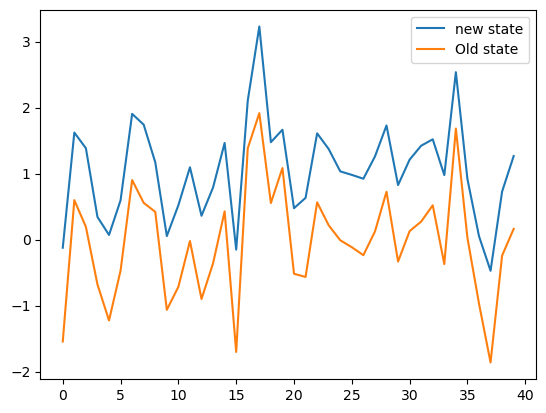

In [265]:
#plt.plot((theta-theta0)[:,0],label="error")
plt.plot(theta[:,0], label = "new state")
plt.plot(theta0[:,0], label= "Old state")
plt.legend()

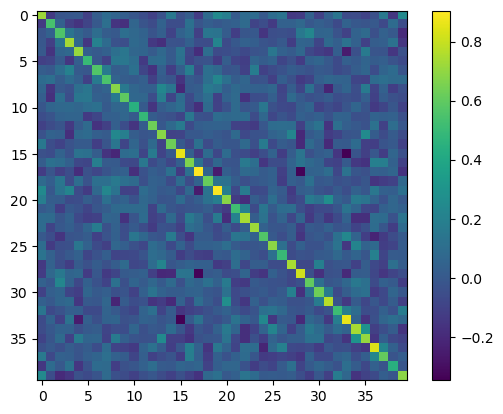

In [266]:

def CGG(Gtheta):
    return np.cov(Gtheta, bias=True)

def CTG(theta, Gtheta):
    """Calculate the cross covariance of the previous state and the next state. 
    Note that for early steps there won't be much correlation"""
    
    num_states = theta.shape[0]
    # https://stackoverflow.com/questions/45134122/numpy-cov-returns-unexpected-output
    return np.cov(np.transpose(theta), np.transpose(Gtheta), bias=True, rowvar=False)[:num_states, num_states:]

plt.imshow(CTG(forward_model(theta0), theta))
plt.colorbar()

In [267]:
# we then define our EKI update step
def EKI_update(theta, Gtheta, y, Gamma, J=J):
    """Update the ensemble of states using the EKI update formula"""
    update = CTG(theta, Gtheta) @ np.linalg.inv(Gamma + CGG(Gtheta)) @ (np.repeat(y, J).reshape(40, J) - Gtheta)
    
    return theta + update, np.linalg.norm(update)
#EKI_update(theta0, theta, y, np.eye(40) * 0.01)

In [289]:
# now we can run the EKI algorithm
iters = 10*40
next_theta = theta0
for i in range(iters):
    next_theta, norm = EKI_update(next_theta, forward_model(next_theta), y, np.eye(40) * .1)
    if i % 20 == 0:
        print(i, norm)
    if norm < 1e-4:
        print(i, norm)
        break

0 48.655846816910426
20 0.15934421243663602
40 0.06655063171752473
60 0.038726919493159026
80 0.026082184492995146
100 0.019098737681127933
120 0.014765975303295632
140 0.011853347380678303
160 0.009790659698305294
180 0.008263610800290349
200 0.007096674229057805
220 0.006181105058442965
240 0.0054467608285437615
260 0.004847014506141265
280 0.004349904693867697
300 0.003932971334810841
320 0.0035776669565704957
340 0.0032732921293215553
360 0.0030098607959671213
380 0.002780516065531267


In [290]:
print(np.linalg.norm(theta0.mean(axis=1) - x0))
np.linalg.norm(next_theta.mean(axis=1) - x0)

5.813571776483793


0.2861071270935901

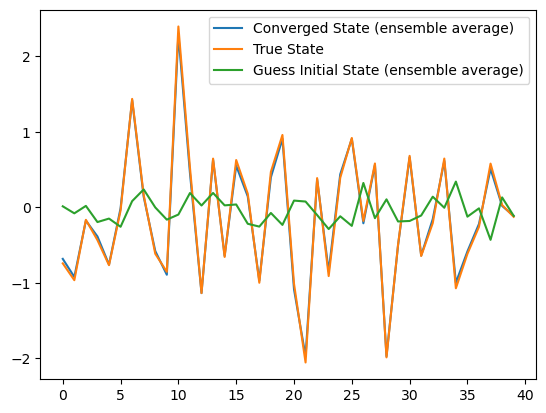

In [291]:
plt.plot(next_theta.mean(axis=1), label="Converged State (ensemble average)")
plt.plot(x0,label="True State")
plt.plot(theta0.mean(axis=1), label="Guess Initial State (ensemble average)")
plt.legend()

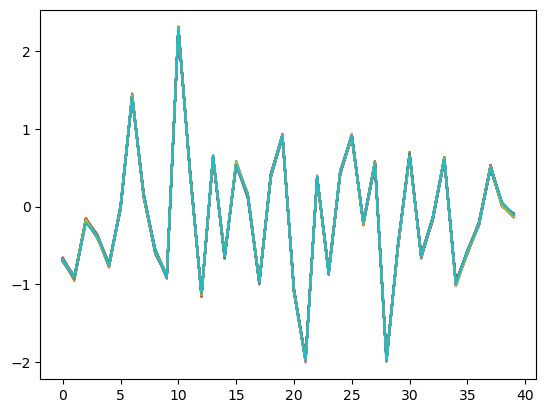

In [356]:
plt.plot(next_theta);

In [ ]:
plt.imshow(next_theta-theta0)
plt.colorbar()

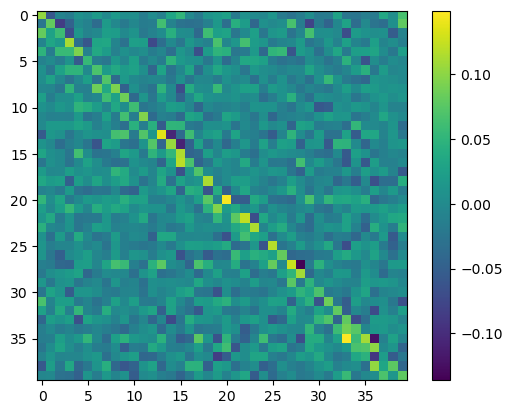

In [292]:
plt.imshow(CTG(theta0, theta) -CGG(theta))
plt.colorbar()

## MCMC 
We are asked to draw samples from the posterior using MCMC. A general posterior looks like:
$$ \pi^y(u) = \frac{1}{Z} \nu(y-\mathcal{G}(u))\rho(u) $$
In our setting the posterior, $\pi^y(u)$, is the posterior of the \textit{initial} condition given an observation, $$\nu(y-\mathcal{G}(u)) \propto \exp\left(-\frac{1}{2}|y-\mathcal{G}(u)|_\Gamma^2 \right)$$ is the likihood function of the initial condition given the observations, $y$, and $\rho(u)$ is the multivariate normal prior we set for the initial condition (which is the same as what the true distribution was drawn from). To implement this we will use the Metropolis-Hastings Algorithm with the following distributions:
Initial sample:
$$ u^{(0)} \sim \pi_0; \;\;\; \pi_0 = \mathcal{MVN}(\vec{0}, I_{40})$$
(Note we could use $\pi_0=\mathcal{MVN}(\text{mean converged EKI}, \text{cov converged EKI})$ if current proposal fails to converge)
$$v^\star \sim q(u^{(n)},v) = \mathcal{MVN}(u^{(n)}-v, \mathbb{I}_{40}) \propto \exp \left[-\frac{1}{2} (u^{(n)}-v)^T\mathbb{I}_{40}(u^{(n)}-v)\right]$$ 

In [341]:
def G(u):
    """Forward model for the Lorenz96 system."""
    return solve_ivp(lorenz96, [0, n_steps*dt], u, t_eval=np.arange(0.0, n_steps*dt, dt)).y.T[-1,:]

def propnu(u, y=y, noise=0.1):
    return np.exp(-0.5 * np.transpose(y - G(u)) @ (np.eye(40) * noise) @ np.linalg.inv(np.eye(40) * noise) @ (y - G(u)))

def q(u):
    return np.random.multivariate_normal(u, np.eye(40))

def propq(u,v):
    return np.exp(-0.5 * np.transpose(u - v) @ np.linalg.inv(np.eye(40)) @ (u - v))

def proprho(u):
    return np.exp(-0.5 * np.transpose(u) @ np.linalg.inv(np.eye(40)) @ u)

def a(u, v):
    return min(1, propnu(v, y) * propq(v,u) * proprho(v) / \
               (propnu(u, y) * propq(u,v) * proprho(u)))

#a(theta0[:,0], theta0[:,9])

0.08647686438678194

In [355]:
# with our functions defined we can now run the MCMC algorithm
n_samples = 10000
samples = np.zeros((n_samples, 40))
samples[0] = theta0[:,0] # random initial guess (just reusing from before)
probs = np.zeros(n_samples)
for i in range(1, n_samples):
    u = samples[i-1]
    v = q(u)
    accept_prob = a(u, v)
    probs[i] = accept_prob
    if np.random.rand() < accept_prob:
        print("Accepted!")
        samples[i] = v
    else:
        samples[i] = u

Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!


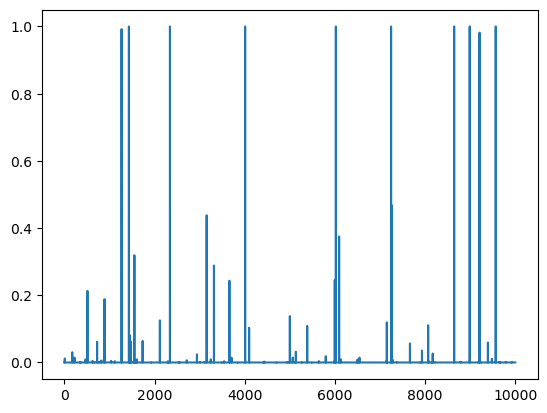

In [357]:
plt.plot(probs)

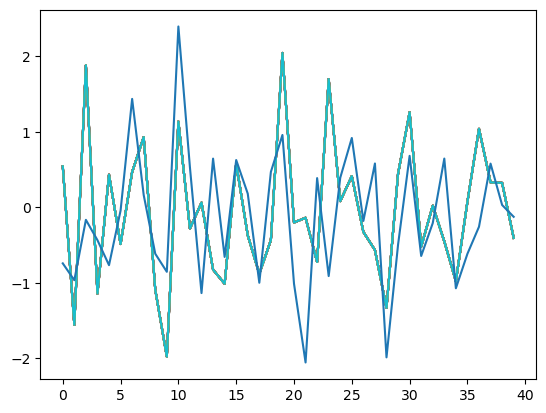

In [358]:
plt.plot(np.transpose(samples[9980:,]))
plt.plot(x0)

## Let's inform our MCMC with the results from the EKI
Use the mean and covariance from final eki result (maybe we'll need to scale up the covariance matrix so it doesn't collapse). These will become both our initial distribution and inform the sampler variance \texttt{q(u)}

In [364]:
# calculate the mean and covariance matrix of EKI result 
mean_eki = next_theta.mean(axis=1)
cov_eki = np.cov(next_theta, bias=True)

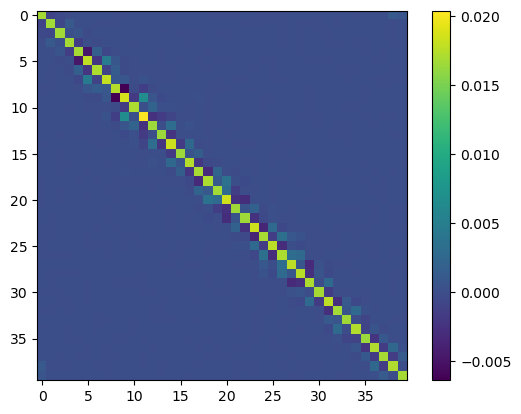

In [370]:
plt.imshow(cov_eki * 100) # cool to see that only local correlations exist
plt.colorbar()

In [371]:
# update q(u) to use the covariance matrix of the EKI result
def q(u):
    return np.random.multivariate_normal(u, cov_eki * 100)

# with our functions defined we can now run the MCMC algorithm
n_samples = 10000
samples = np.zeros((n_samples, 40))

# update initial guess to use the mean of the eki result 
samples[0] = mean_eki

# run Metropolis Hastings
probs = np.zeros(n_samples)
accepts = 0
for i in range(1, n_samples):
    u = samples[i-1]
    v = q(u)
    accept_prob = a(u, v)
    probs[i] = accept_prob
    if np.random.rand() < accept_prob:
        accepts += 1/n_samples
        samples[i] = v
    else:
        samples[i] = u

Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!


Text(0.5, 1.0, 'EKI Informed MCMC Sampling of Lorenz96 System (cov-upweighting by 100)')

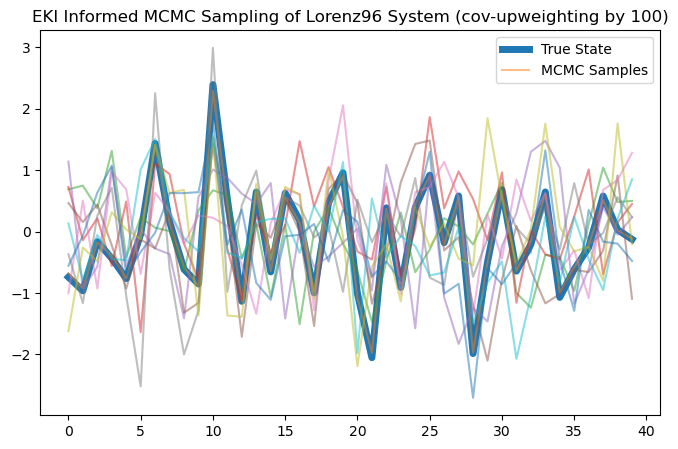

In [387]:
plt.figure(figsize=(8,5))
plt.plot(x0, linewidth=5)
plt.plot(np.transpose(samples[::1000]), alpha=.5) # get every 1000th sample to reduce correlation
plt.legend(["True State", "MCMC Samples"])
plt.title("EKI Informed MCMC Sampling of Lorenz96 System (cov-upweighting by 100)")

In [379]:
# get every 100th sample to reduce correlation
samples[::100].shape

(100, 40)

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(x0, linewidth=5)
plt.plot(np.transpose(samples[::1000]), alpha=.5) # get every 1000th sample to reduce correlation
plt.legend(["True State", "MCMC Samples"])
plt.title("EKI Informed MCMC Sampling of Lorenz96 System (cov-upweighting by 100)")

### TODO
Assess how frequently we should subsample by looking at the correlation

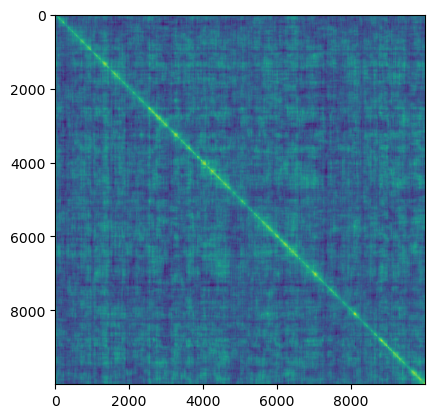

In [390]:
plt.imshow(np.cov(samples))

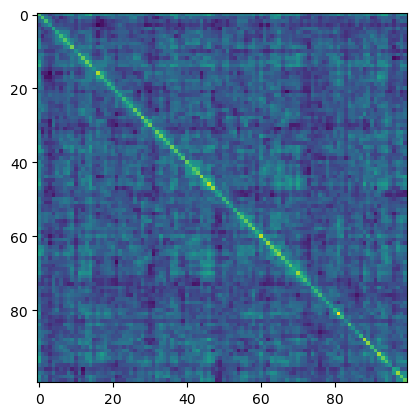

In [392]:
plt.imshow(np.cov(samples[::100]))